## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# select plot style
plt.style.use('fivethirtyeight')

## Load dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Inspect dataset

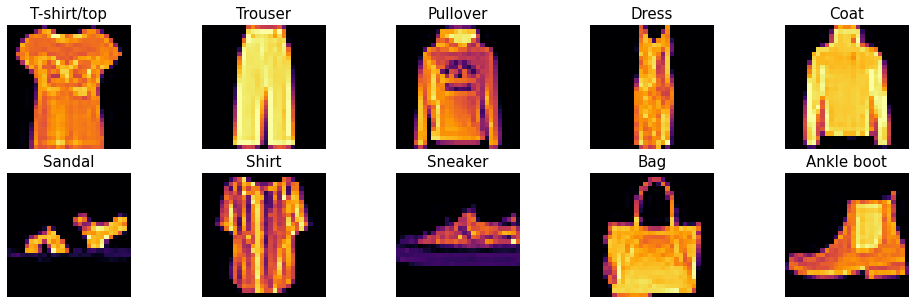

In [3]:
# Declare which number(index) corresponds to which class
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(2,5,figsize=(15,5))
for label in range(10):
    idx = np.random.choice(np.where(test_labels==label)[0])
    ax[label//5,label%5].imshow(test_images[idx], cmap = "inferno")
    ax[label//5,label%5].set_title(classes[test_labels[idx]], fontsize=15)
    ax[label//5,label%5].axis("off")

## Data Pipeline

In [4]:
# combine images and labels into a tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(-1, 28, 28, 1))
test_dataset = tf.data.Dataset.from_tensor_slices(test_images.reshape(-1, 28, 28, 1))                                         

# create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


# normalize images and encode labels onehot
train_dataset = train_dataset.map(lambda image:(image/255), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda image: (image/255), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

# shuffle data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)   

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Generator
The Generator gets a random point from the latent space
and returns an image

In [195]:
class Generator(Model):

  def __init__(self, embedding_size = 10):
    super(Generator, self).__init__()

    self.input_layer = tf.keras.layers.Input(shape = embedding_size)

    self.my_layers = [
            tf.keras.layers.Dense(units=28*28*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(28, 28, 64)),

          

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=1, padding='same',
                activation='relu'),

           
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=1, padding='same',
                activation='relu'),


            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=2, strides=1, padding='same',
                activation='relu'),

  

          

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=2, strides=1, padding='same',
                activation = "sigmoid"),
        ]

    self.out = self.call(self.input_layer)

  def call(self, x):
    for layer in self.my_layers:
      x = layer(x)
    return x

## Test Generator

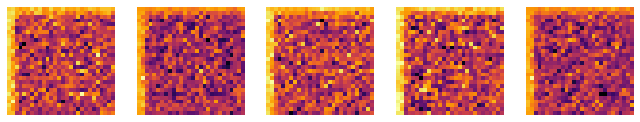

In [196]:
gen = Generator(10)

noise = tf.random.normal([5, 10])

images = gen(noise)

fig, ax = plt.subplots(1, 5, figsize=(10,10))
for index, image in enumerate(images):
    ax[index].imshow(image.numpy().squeeze(),cmap = "inferno")
    ax[index].axis('off')

In [197]:
gen.summary()

Model: "generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50176)             551936    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 64)        16448     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 128)       32896     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 28, 28, 256)       131328    
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 1)         1025      
Total params: 733,633
Trainable params: 733,633
Non-trainable params: 0
_________________________________________________

## Discriminator
The Discriminator takes images and returns whether it thinks they are real or fake

In [198]:
class Discriminator(Model):
  def __init__(self, clipping = None):
    super(Discriminator, self).__init__()

    self.input_layer = tf.keras.layers.Input(shape = (28,28,1))

    self.my_layers = [
            tf.keras.layers.Conv2D(
                              filters = 16, 
                              kernel_size = 4, 
                              strides = 1, 
                              padding = "same",
                              activation='relu',
                              kernel_constraint = clipping),
         
            
            
            tf.keras.layers.Conv2D(
                              filters = 64, 
                              kernel_size = 3, 
                              strides = 1, 
                              padding = "same",
                              activation ='relu',
                              kernel_constraint = clipping),
           
            
                      
            tf.keras.layers.Conv2D(
                              filters = 128, 
                              kernel_size = 2, 
                              strides = 1, 
                              padding = "same",
                              activation ='relu',
                              kernel_constraint = clipping),
          
         
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(
                              1,
                              activation = None),
        ]

    self.out = self.call(self.input_layer)

  def call(self, x):
    for layer in self.my_layers:
      x = layer(x)
    return x

## Test Discriminator

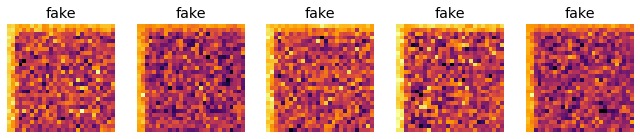

In [199]:
dis = Discriminator()

real_fake_assessment = dis(images)

fig, ax = plt.subplots(1, 5, figsize=(10,10))
for index, image in enumerate(images):
    ax[index].imshow(image.numpy().squeeze(),cmap = "inferno")
    ax[index].set_title(["real" if ass>0.5 else "fake" for ass in real_fake_assessment][index])
    ax[index].axis('off')

In [200]:
dis.summary()


Model: "discriminator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 16)        272       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        9280      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       32896     
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 100353    
Total params: 142,801
Trainable params: 142,801
Non-trainable params: 0
_________________________________________________________________


## Define training

In [201]:
def train_step(gen, dis, real_images, d_optimizer, g_optimizer):

    # first we generate fake images using the generator
    embedding_size = gen.input_layer.shape[1]
    image_num = real_images.shape[0]
    noise = tf.random.normal([image_num, embedding_size])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

        generated_images = gen(noise)
        
        # get predictions from discriminator
        # values are in interval of [0-infinite)
        # 0 means real
        # - fake, + real
        pred_for_real = dis(real_images)
        pred_for_fake = dis(generated_images)


        # discriminator loss
        dis_loss = -(tf.reduce_mean(pred_for_real) - tf.reduce_mean(pred_for_fake))
        # generator loss
        gen_loss = -tf.reduce_mean(pred_for_fake)

    # apply gradients
    gradients_dis = dis_tape.gradient(dis_loss, dis.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients_dis, dis.trainable_variables))

    
    # apply gradients
    gradients_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_gen, gen.trainable_variables))


    #optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return [dis_loss, gen_loss]



def test(gen, dis, test_data):
    # Test over complete test data
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    embedding_size = gen.input_layer.shape[1]

    real_loss_aggregator = []
    fake_loss_aggregator = []

    pred_for_fake_aggregator = []

    # First we get predictions from the discriminator
    # for real images and calculate the discriminator loss
    for image in test_data:
        pred_for_real = dis(image)
        real_loss = bce(tf.ones(pred_for_real.shape), pred_for_real)
        real_loss_aggregator.append(np.mean(real_loss.numpy()))

    real_loss = np.mean(real_loss_aggregator) 

    # Then we repeat the procedure for fake images
    for i in range(len(test_data)):
      noise = tf.random.normal([1, embedding_size])
      generated_image = gen(noise)
      pred_for_fake = dis(generated_image)
      pred_for_fake_aggregator.append(pred_for_fake)
      fake_loss = bce(tf.zeros(pred_for_fake.shape), pred_for_fake)
      fake_loss_aggregator.append(np.mean(fake_loss.numpy()))

    fake_loss = np.mean(real_loss_aggregator) 

    dis_loss = real_loss + fake_loss

    # calculate the generator loss
    gen_loss = bce(tf.ones(np.array(pred_for_fake_aggregator).shape), np.array(pred_for_fake_aggregator))

    return [dis_loss, gen_loss]

## Train model and observe progress

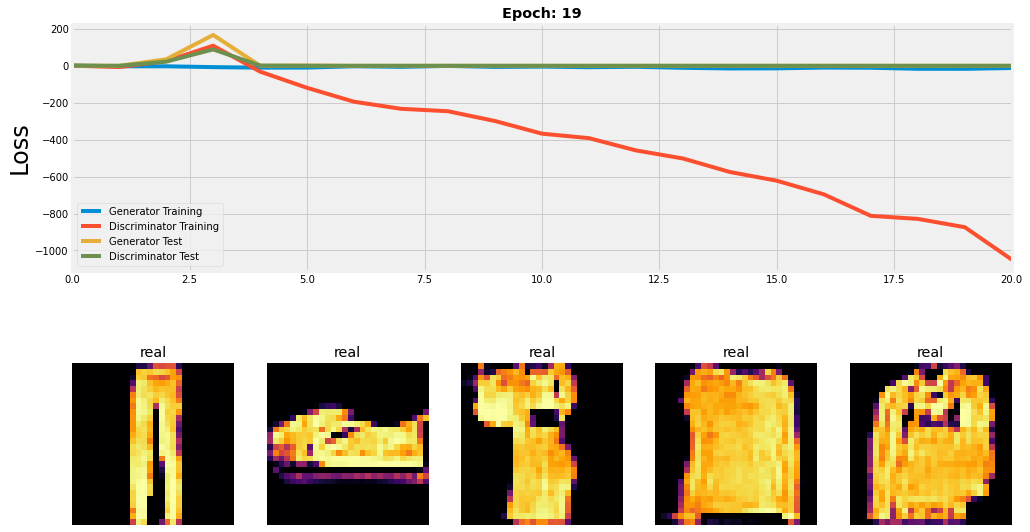

Train loss generator:  -12.031623
Train loss discriminator:  -1049.3936
Test loss generator:  0.0
Test loss discriminator:  0.0


In [203]:
#%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 20
learning_rate = 0.0001
embedding_size = 100
running_average_factor = 0.95

### Models
gen = Generator(embedding_size)

clipping = tf.keras.constraints.MinMaxNorm(
    min_value=-0.01, max_value=0.01, rate=1.0, axis=0
)
dis = Discriminator()


# Initialize the optimizer
d_optimizer = tf.keras.optimizers.RMSprop(learning_rate)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize lists for later visualization.
train_losses_gen = []
test_losses_gen = []

train_losses_dis = []
test_losses_dis = []

# Testing model performance on train and test data before learning
train_loss_gen, train_loss_dis = test(gen, dis, train_dataset)
train_losses_gen.append(train_loss_gen)
train_losses_dis.append(train_loss_dis)

test_loss_gen, test_loss_dis = test(gen, dis, test_dataset)
test_losses_gen.append(train_loss_gen)
test_losses_dis.append(train_loss_dis)




# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss_gen = 0
    running_average_loss_dis = 0
    for image in train_dataset:
        train_loss_gen, train_loss_dis  = train_step(gen, dis, image, d_optimizer, g_optimizer)
        running_average_loss_gen = running_average_factor * running_average_loss_gen  + (1 - running_average_factor) * train_loss_gen
        running_average_loss_dis = running_average_factor * running_average_loss_dis  + (1 - running_average_factor) * train_loss_dis
        
    train_losses_gen.append(running_average_loss_gen)
    train_losses_dis.append(running_average_loss_dis)
   

    # Testing
    test_loss_gen, test_loss_dis = test(gen, dis, test_dataset)
    test_losses_gen.append(test_loss_gen)
    test_losses_dis.append(test_loss_dis)

    # each epoch we use our generator to produce 5 images from noise
    # and let them be evaluated by the discriminator
    num_images = 5
    noise = tf.random.normal([num_images, embedding_size])
    images = gen(noise)
    real_fake_assessment = dis(images)


    clear_output(wait=True) 
    fontsize=24

    fig = plt.figure(figsize = (15,10))

    loss_plot = fig.add_subplot(2,1,1)
    loss_plot.set_xlim((0,num_epochs))
    loss_plot.plot(train_losses_gen,label="Generator Training")
    loss_plot.plot(train_losses_dis,label="Discriminator Training")
    loss_plot.plot(test_losses_gen,label="Generator Test")
    loss_plot.plot(test_losses_dis,label="Discriminator Test")
    loss_plot.set_ylabel("Loss",fontsize=fontsize)
    loss_plot.set_title("Epoch: " + str(epoch), fontweight="bold")
    loss_plot.legend()

    for i in range(num_images):
      img_plot = fig.add_subplot(2,5,6+i)
      img_plot.imshow(images.numpy().squeeze()[i], cmap = "inferno")
      img_plot.set_title(["real" if ass>0.0 else "fake" for ass in real_fake_assessment][index])
      img_plot.axis("off")

    plt.show()

    print('Train loss generator: ',running_average_loss_gen.numpy())
    print('Train loss discriminator: ',running_average_loss_dis.numpy())
    print('Test loss generator: ',test_loss_gen)
    print('Test loss discriminator: ',test_loss_dis.numpy())